Test imaging of single FITS files / explore data

In [80]:
import os
import matplotlib.pyplot as plt
from astropy.io import fits
import numpy as np
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from scipy.optimize import curve_fit
import glob
from astropy.time import Time
from datetime import datetime
from collections import defaultdict
import importlib
utils = importlib.import_module('utils')
importlib.reload(utils)
from utils import *

crab_img_directories = ["../data/Crab/3-15keV/Images", "../data/Crab/15-30keV/Images", "../data/Crab/30-60keV/Images"]
jupiter_img_directories = ["../data/Jupiter/3-15keV/Images", "../data/Jupiter/15-30keV/Images", "../data/Jupiter/30-60keV/Images"]

crab_files = [np.sort(os.listdir(directory)) for directory in crab_img_directories]
jupiter_files = [np.sort(os.listdir(directory)) for directory in jupiter_img_directories]

In [81]:
crab_coords = SkyCoord.from_name("Crab")
crab_ra, crab_dec = crab_coords.ra.deg, crab_coords.dec.deg

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]
Invalid DATE-OBS format 'UTC_format'.
Invalid DATE-END format 'UTC_format''. [astropy.wcs.wcs]
/tmp/ipykernel_3221/1656297790.py:9: RuntimeWarning: invalid value encountered in log10
  im = ax.imshow(np.log10(crab_img), cmap='viridis', origin='lower', aspect='equal')


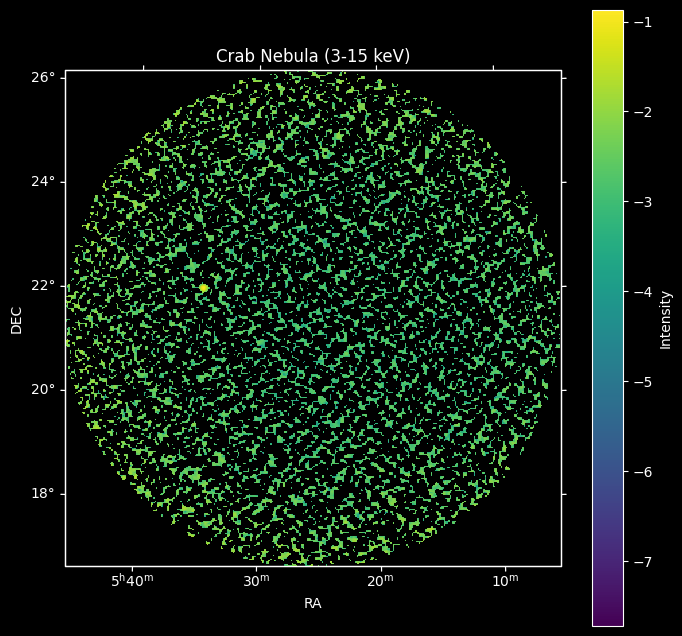

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-OBS to 60732.287037 from DATE-OBS.
Set MJD-END to 60732.319201 from DATE-END'. [astropy.wcs.wcs]
/tmp/ipykernel_3221/1656297790.py:9: RuntimeWarning: divide by zero encountered in log10
  im = ax.imshow(np.log10(crab_img), cmap='viridis', origin='lower', aspect='equal')
/tmp/ipykernel_3221/1656297790.py:9: RuntimeWarning: invalid value encountered in log10
  im = ax.imshow(np.log10(crab_img), cmap='viridis', origin='lower', aspect='equal')


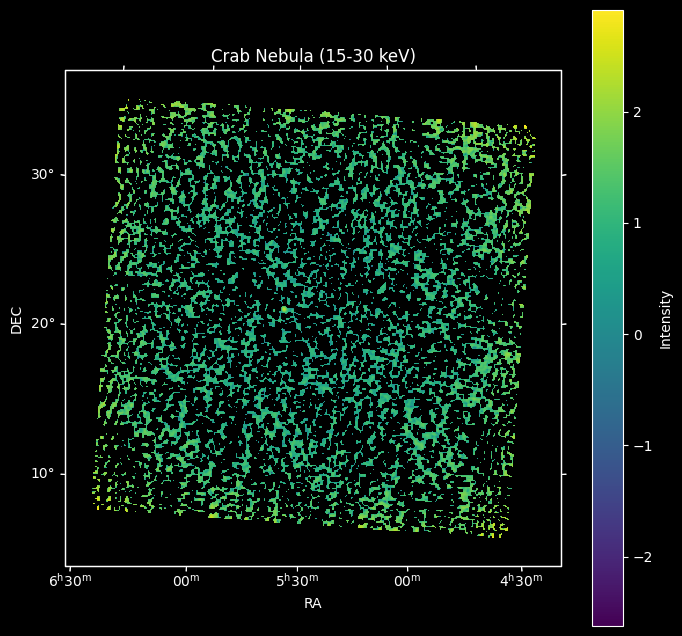

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-OBS to 60732.287037 from DATE-OBS.
Set MJD-END to 60732.319201 from DATE-END'. [astropy.wcs.wcs]
/tmp/ipykernel_3221/1656297790.py:9: RuntimeWarning: divide by zero encountered in log10
  im = ax.imshow(np.log10(crab_img), cmap='viridis', origin='lower', aspect='equal')
/tmp/ipykernel_3221/1656297790.py:9: RuntimeWarning: invalid value encountered in log10
  im = ax.imshow(np.log10(crab_img), cmap='viridis', origin='lower', aspect='equal')


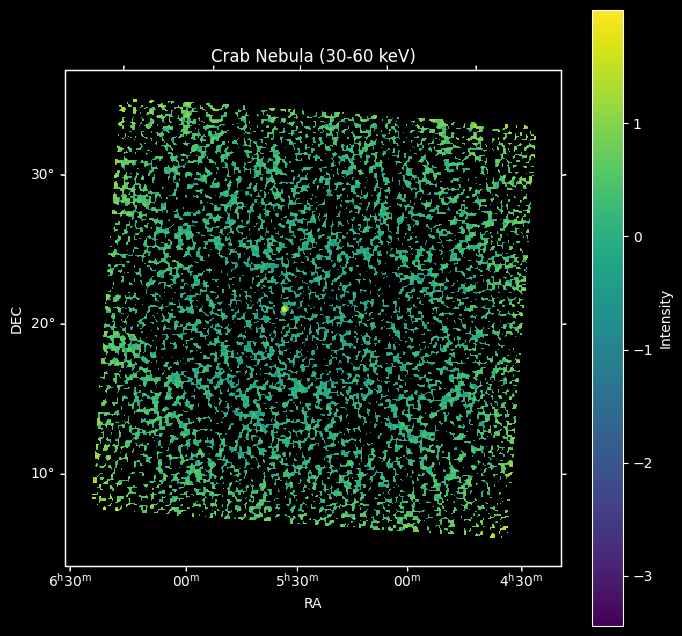

In [82]:
for i, directory in enumerate(crab_img_directories):
    with fits.open(os.path.join(directory, crab_files[i][-1])) as hdu:
        crab_img = hdu[2].data
        wcs = WCS(hdu[2].header)

    fig = plt.figure(figsize=(8, 8))
    plt.style.use('dark_background')
    ax = fig.add_subplot(111, projection=wcs)  # Create a new figure for each image with WCS projection
    im = ax.imshow(np.log10(crab_img), cmap='viridis', origin='lower', aspect='equal')

    ax.set_xlabel('RA')
    ax.set_ylabel('DEC')
    if i == 0:
        E1, E2 = 3, 15
    elif i == 1:
        E1, E2 = 15, 30
    else:
        E1, E2 = 30, 60
    ax.set_title(f"Crab Nebula ({E1}-{E2} keV)")

    cbar = plt.colorbar(im, ax=ax, label="Intensity")
    
    plt.style.use('dark_background')
    plt.show()

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-OBS to 54559.124931 from DATE-OBS.
Set MJD-END to 54559.166273 from DATE-END'. [astropy.wcs.wcs]
/tmp/ipykernel_3221/3471127238.py:10: RuntimeWarning: divide by zero encountered in log10
  im = ax.imshow(np.log10(j_img), cmap='viridis', origin='lower', aspect='equal')
/tmp/ipykernel_3221/3471127238.py:10: RuntimeWarning: invalid value encountered in log10
  im = ax.imshow(np.log10(j_img), cmap='viridis', origin='lower', aspect='equal')


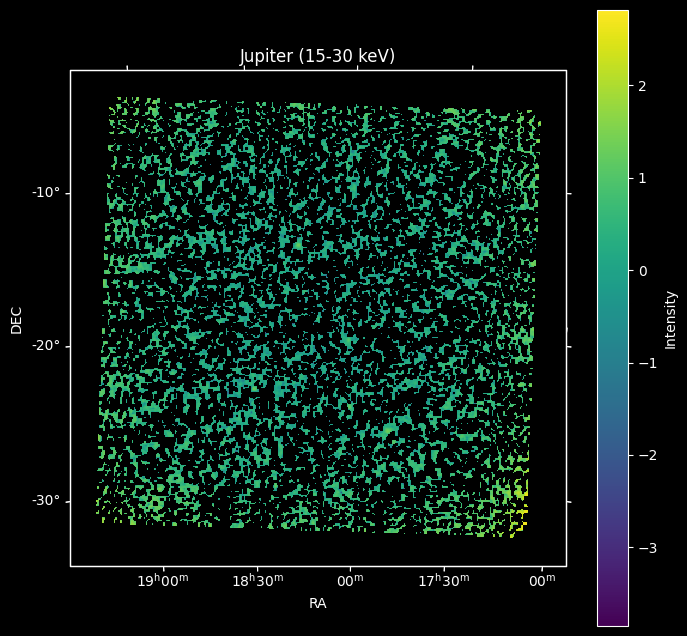

In [28]:
for i, directory in enumerate(jupiter_img_directories):
    if not i == 1: # for now only 15-30keV data is available
        continue
    with fits.open(os.path.join(directory, jupiter_files[1][0])) as hdu:
        j_img = hdu[2].data
        wcs = WCS(hdu[2].header)

    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection=wcs)  # Create a new figure for each image with WCS projection
    im = ax.imshow(np.log10(j_img), cmap='viridis', origin='lower', aspect='equal')

    ax.set_xlabel('RA')
    ax.set_ylabel('DEC')
    if i == 0:
        E1, E2 = 3, 15
    elif i == 1:
        E1, E2 = 15, 30
    else:
        E1, E2 = 30, 60
    ax.set_title(f"Jupiter ({E1}-{E2} keV)")

    cbar = plt.colorbar(im, ax=ax, label="Intensity")
    
    plt.style.use('dark_background')
    plt.show()

Gaussian fitting

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-OBS to 60732.287037 from DATE-OBS.
Set MJD-END to 60732.319201 from DATE-END'. [astropy.wcs.wcs]


Crab single pixel count rate: 191.32 +/- 3.42
Crab PSF count rate using amplitude + position: 46.24 +/- 4.24
Crab PSF count rate using all parameters: 206.32 +/- 16.60


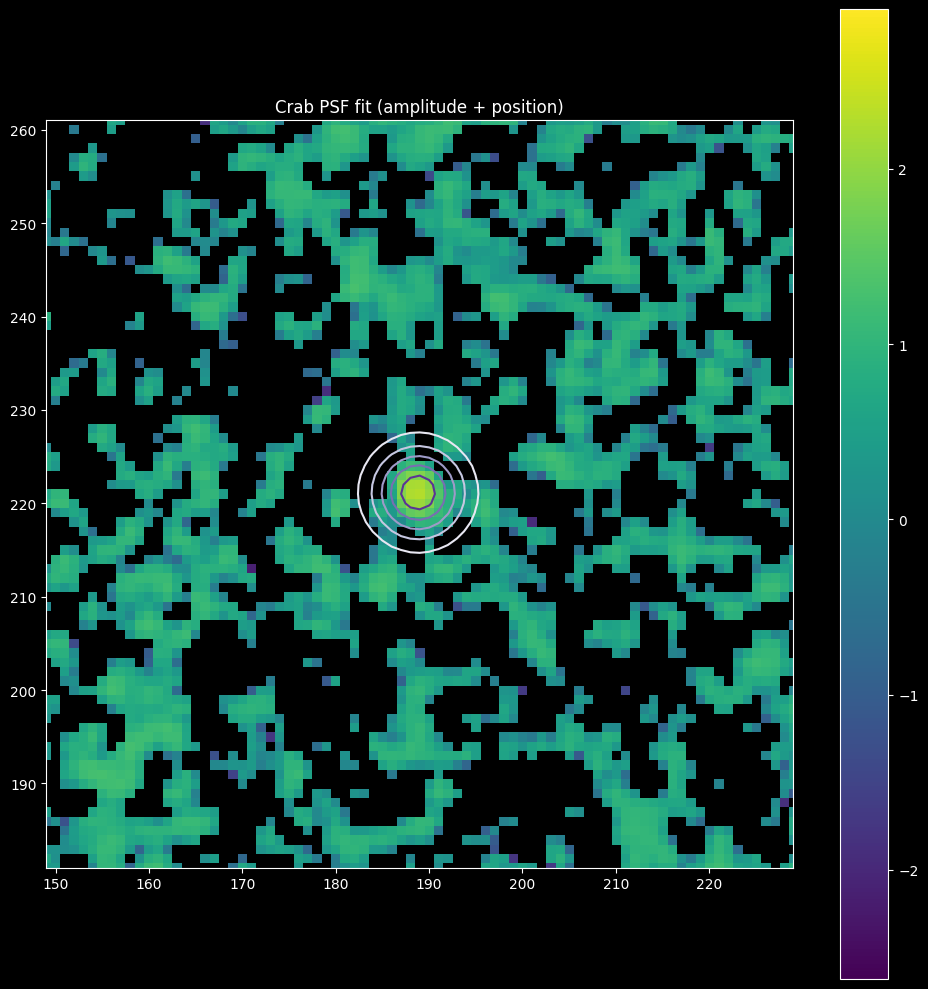

In [ ]:
with fits.open(os.path.join(crab_img_directories[1], crab_files[0][-1])) as hdu:
    crab_img = hdu[2].data
    crab_var = hdu[3].data

    wcs = WCS(hdu[2].header)
    x, y = wcs.all_world2pix(crab_ra, crab_dec, 0)
    x_int, y_int = int(round(x.item())), int(round(y.item()))
    crab_countrate = crab_img[y_int, x_int]
    crab_variance = crab_var[y_int, x_int]
    
x = np.arange(0, crab_img.shape[1])
y = np.arange(0, crab_img.shape[0])
x, y = np.meshgrid(x, y)

def Gaussian2D_fixed(xy, amplitude, xo, yo):
    return Gaussian2D(xy, amplitude, xo, yo, np.sqrt(crab_variance), np.sqrt(crab_variance), 0, 0)

print(f"Crab single pixel count rate: {crab_countrate:.2f} +/- {np.sqrt(crab_variance):.2f}")

# Fit the data with the Gaussian2D model, fit only the amplitude and the position
from scipy.optimize import curve_fit
popt, pcov = curve_fit(Gaussian2D_fixed, (x, y), crab_img.ravel(), p0=[crab_countrate, x_int, y_int])# , sigma=np.sqrt(var_data.ravel())
popt2, pcov2 = curve_fit(Gaussian2D, (x, y), crab_img.ravel(), p0=[crab_countrate, x_int, y_int,  np.sqrt(crab_variance),  np.sqrt(crab_variance), 0, 0])
crab_psf_countrate_fixed = popt[0]
crab_psf_countrate = popt2[0]
crab_psf_error_fixed = np.sqrt(np.diag(pcov))[0]
crab_psf_error = np.sqrt(np.diag(pcov2))[0]

print(f"Crab PSF count rate using amplitude + position: {crab_psf_countrate_fixed:.2f} +/- {crab_psf_error_fixed:.2f}")
print(f"Crab PSF count rate using all parameters: {crab_psf_countrate:.2f} +/- {crab_psf_error:.2f}")

# Plot the fit of the Gaussian2DS model centered on the Crab
plt.figure(figsize=(10, 10))
plt.style.use('dark_background')
plt.imshow(np.log10(np.where(crab_img > 0, crab_img, np.nan)), cmap='viridis', origin='lower')
plt.colorbar()
plt.contour(x, y, Gaussian2D_fixed((x, y), *popt).reshape(crab_img.shape), cmap='Purples', levels=5)
#plt.contour(x, y, Gaussian2D((x, y), *popt2).reshape(crab_img.shape), cmap='Purples', levels=5)
plt.xlim(x_int-40, x_int+40)
plt.ylim(y_int-40, y_int+40)
plt.title("Crab PSF fit (amplitude + position)")
plt.tight_layout()

FITS header exploration

In [96]:
jemx_header = fits.open(os.path.join(crab_img_directories[0], crab_files[0][5]))[2].header
jemx_header['IMATYPE']

IndexError: list index out of range

Using new table

In [37]:
from astropy.io import ascii
from astropy.time import Time
from astropy.io import fits
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from astropy.wcs.utils import skycoord_to_pixel
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.wcs import WCS
from scipy.optimize import curve_fit
import glob
from datetime import datetime
from collections import defaultdict
import importlib
utils = importlib.import_module('utils')
importlib.reload(utils)
from utils import *

jupiter_table = ascii.read('../data/jupiter_table.dat')

jupiter_ra = jupiter_table['jupiter_ra'].data # ICRS
jupiter_dec = jupiter_table['jupiter_dec'].data

jdates = jupiter_table['start_date'].data # MJD
jdates = [Time(jd, format="mjd").datetime for jd in jdates]

jscws = [str(scw).zfill(12) for scw in jupiter_table['scw_id'].data]

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-OBS to 58781.030093 from DATE-OBS.
Set MJD-END to 58781.053970 from DATE-END'. [astropy.wcs.wcs]


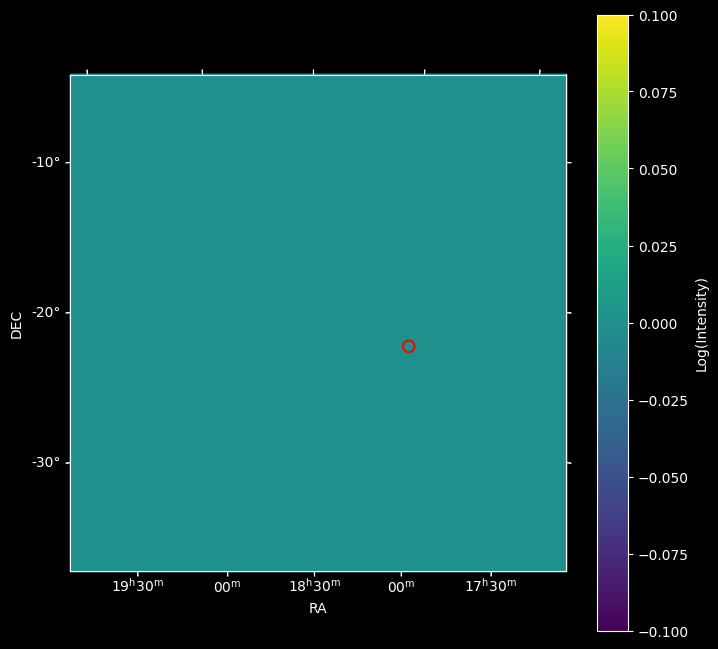

In [85]:
new_dir = '../data/Jupiter/15-30keV/Images/'
new_files = os.listdir(new_dir)

# idx = np.random.randint(0, len(new_files))
# idx = new_files.index('236600210010.001mosaic.fits')
idx = new_files.index('215200060010.001mosaic.fits')

with fits.open(os.path.join(new_dir, new_files[idx])) as hdu:
    j_img = hdu[2].data
    wcs = WCS(hdu[2].header)

idx = jscws.index(new_files[idx][:12])
j_coord = SkyCoord(jupiter_ra[idx], jupiter_dec[idx], unit="deg")
j_x, j_y = skycoord_to_pixel(j_coord, wcs)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection=wcs)
im = ax.imshow(j_img, cmap='viridis', origin='lower', aspect='equal')

circle = Circle((j_x, j_y), radius=5, edgecolor='red', facecolor='none', linewidth=1.5)
ax.add_patch(circle)

ax.set_xlabel('RA')
ax.set_ylabel('DEC')
cbar = plt.colorbar(im, ax=ax, label="Log(Intensity)")
plt.style.use('dark_background')
plt.show()
